<a href="https://colab.research.google.com/github/midnight-koffee/HoML/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Given two categories of data, say $\pm 1$ and lots of data associated to each category. Each data point could possibly be in $\mathbb{R}^{n}$ for any natural number $n$. We want to create a line/plane in $R^{n}$ which would partition the two categories. Thus if we get a new data point whose category is unknown, we can fit it in the equation of the line, and depending on the sign of the expression, we can conclude if the point lies above the plane of below the plane, thus we would have categorised it into either $\pm$ 1

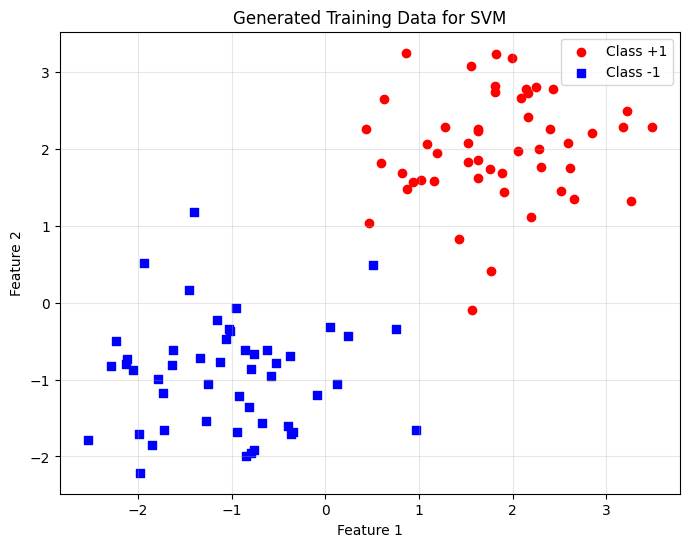

Data shape: (100, 2)
Labels shape: (100,)
Unique labels: [-1.  1.]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data for class +1 (centered around (2, 2))
n_samples_per_class = 50
class_1_x = np.random.normal(2, 0.8, n_samples_per_class)
class_1_y = np.random.normal(2, 0.8, n_samples_per_class)
class_1_data = np.column_stack((class_1_x, class_1_y))
class_1_labels = np.ones(n_samples_per_class)

# Generate data for class -1 (centered around (-1, -1))
class_neg1_x = np.random.normal(-1, 0.8, n_samples_per_class)
class_neg1_y = np.random.normal(-1, 0.8, n_samples_per_class)
class_neg1_data = np.column_stack((class_neg1_x, class_neg1_y))
class_neg1_labels = -np.ones(n_samples_per_class)

# Combine all data
X = np.vstack((class_1_data, class_neg1_data))
y = np.hstack((class_1_labels, class_neg1_labels))

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], c='red', marker='o', label='Class +1')
plt.scatter(class_neg1_data[:, 0], class_neg1_data[:, 1], c='blue', marker='s', label='Class -1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Training Data for SVM')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")


When the data points reside in a 2D plane. The problem reduces to finding variables $a$, $b$ and $c$ such that $ax+by+c = 0$ will be the line differentiating the given two categories.

We want to construct such a line that will keep the maximum margin from the nearest point from both categories. The distance of point $(x_{1}, y_{1})$ frm the line $ax+by+c$ is $\frac{ax_{1}+by_{1}+c}{\sqrt{a^{2}+b^{2}}}$.

Thus we want to minimize $\sqrt{a^{2}+b^{2}}$ subject to the condition that for all $(x,y)$ in class 1 $ax+by+c$ is greater than 0 and less than 0 for the other class. This very condition is modified and told that $\text{Class Label} \times (ax+by+c) \geq 1$, where class label is the label of the data point $(x,y)$


In [2]:
pip install numpy matplotlib cvxopt


In [3]:
from scipy.optimize import minimize

def solve_svm_2d(X, y):
    """
    Solve the SVM optimization problem for 2D data

    Minimize: sqrt(a² + b²) (equivalently: a² + b²)
    Subject to: y_i * (a*x_i + b*y_i + c) >= 1 for all i

    Parameters:
    X: array of shape (n_samples, 2) - feature matrix (already exists)
    y: array of shape (n_samples,) - labels (+1 or -1) (already exists)

    Returns:
    a, b, c: coefficients of the separating line ax + by + c = 0
    """

    # Objective function: minimize a² + b²
    def objective(params):
        a, b, c = params
        return a**2 + b**2

    # Constraint functions: y_i * (a*x_i + b*y_i + c) >= 1
    def create_constraint(xi, yi, label):
        def constraint(params):
            a, b, c = params
            return label * (a * xi + b * yi + c) - 1.0
        return constraint

    # Create constraint list
    constraints = []
    for i in range(len(X)):
        xi, yi = X[i, 0], X[i, 1]
        label = y[i]
        constraints.append({
            'type': 'ineq',
            'fun': create_constraint(xi, yi, label)
        })

    # Initial guess
    initial_params = np.array([1.0, 1.0, 0.0])

    # Solve the optimization problem
    result = minimize(
        objective,
        initial_params,
        method='SLSQP',
        constraints=constraints,
        options={'ftol': 1e-9, 'disp': True}
    )

    if result.success:
        a, b, c = result.x
        print(f"Optimization successful!")
        print(f"Line equation: {a:.4f}x + {b:.4f}y + {c:.4f} = 0")
        print(f"Margin width: {2/np.sqrt(a**2 + b**2):.4f}")
        return a, b, c, result
    else:
        print(f"Optimization failed: {result.message}")
        return None, None, None, result

# Solve the SVM problem using existing data
a, b, c, result = solve_svm_2d(X, y)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 32.1023849778128
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization successful!
Line equation: 4.0840x + 3.9272y + -5.0132 = 0
Margin width: 0.3530


Support vector indices: []
Number of support vectors: 0


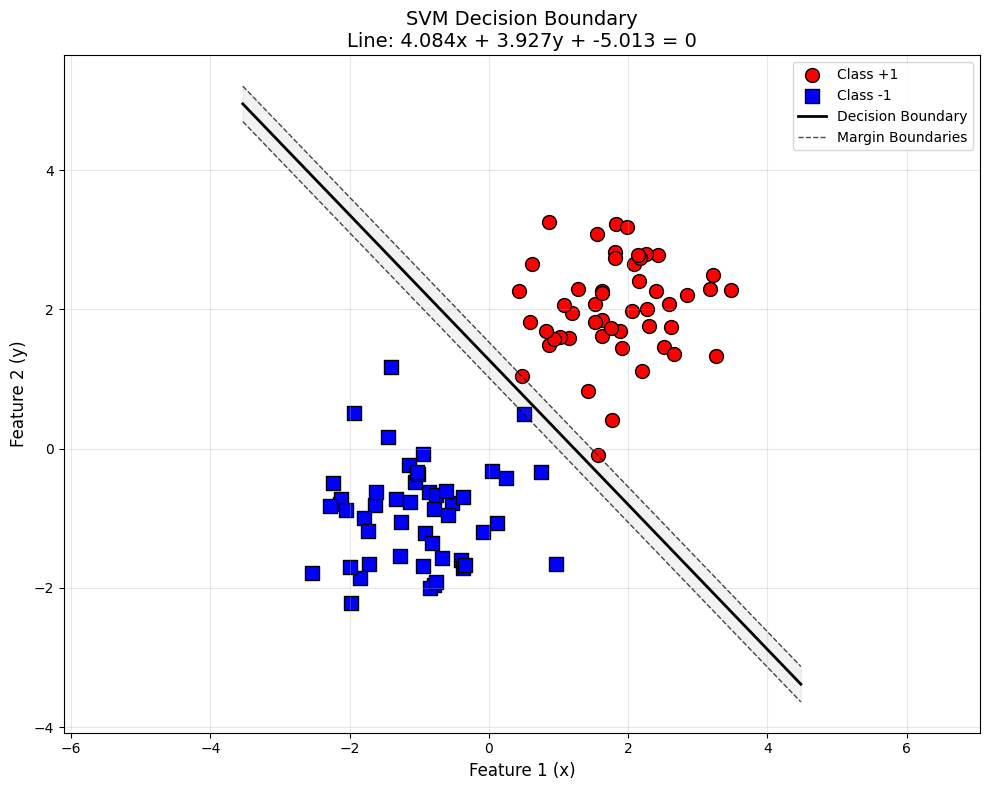

In [4]:
def plot_svm_result(X, y, a, b, c):
    """
    Visualize the SVM result with data points, decision boundary, and margins
    """
    plt.figure(figsize=(10, 8))

    # Plot data points
    mask_pos = y == 1
    mask_neg = y == -1

    plt.scatter(X[mask_pos, 0], X[mask_pos, 1], c='red', marker='o',
                s=100, label='Class +1', edgecolors='black', linewidth=1)
    plt.scatter(X[mask_neg, 0], X[mask_neg, 1], c='blue', marker='s',
                s=100, label='Class -1', edgecolors='black', linewidth=1)

    # Create x range for plotting lines
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_range = np.linspace(x_min, x_max, 100)

    # Calculate y values for the decision boundary: ax + by + c = 0 => y = -(ax + c)/b
    if abs(b) > 1e-10:  # Avoid division by zero
        y_decision = -(a * x_range + c) / b
        y_margin_pos = -(a * x_range + c - 1) / b  # ax + by + c = 1
        y_margin_neg = -(a * x_range + c + 1) / b  # ax + by + c = -1

        # Plot lines
        plt.plot(x_range, y_decision, 'k-', linewidth=2, label='Decision Boundary')
        plt.plot(x_range, y_margin_pos, 'k--', linewidth=1, alpha=0.7, label='Margin Boundaries')
        plt.plot(x_range, y_margin_neg, 'k--', linewidth=1, alpha=0.7)

        # Fill margin area
        plt.fill_between(x_range, y_margin_pos, y_margin_neg, alpha=0.1, color='gray')

    # Find and highlight support vectors
    support_vectors = []
    tolerance = 1e-4

    for i in range(len(X)):
        xi, yi = X[i, 0], X[i, 1]
        distance = abs(a * xi + b * yi + c) / np.sqrt(a**2 + b**2)
        if abs(distance - 1.0) < tolerance:
            support_vectors.append(i)
            plt.scatter(xi, yi, s=200, facecolors='none', edgecolors='green',
                       linewidth=3, label='Support Vector' if i == support_vectors[0] else "")

    plt.xlabel('Feature 1 (x)', fontsize=12)
    plt.ylabel('Feature 2 (y)', fontsize=12)
    plt.title(f'SVM Decision Boundary\nLine: {a:.3f}x + {b:.3f}y + {c:.3f} = 0', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')

    print(f"Support vector indices: {support_vectors}")
    print(f"Number of support vectors: {len(support_vectors)}")

    plt.tight_layout()
    plt.show()

# Plot the results using existing data
if a is not None:
    plot_svm_result(X, y, a, b, c)


New point: (798.500, 7671.500)
Decision value: 33383.9428
Predicted class: 1
Distance from decision boundary: 5892.0847
Confidence: High


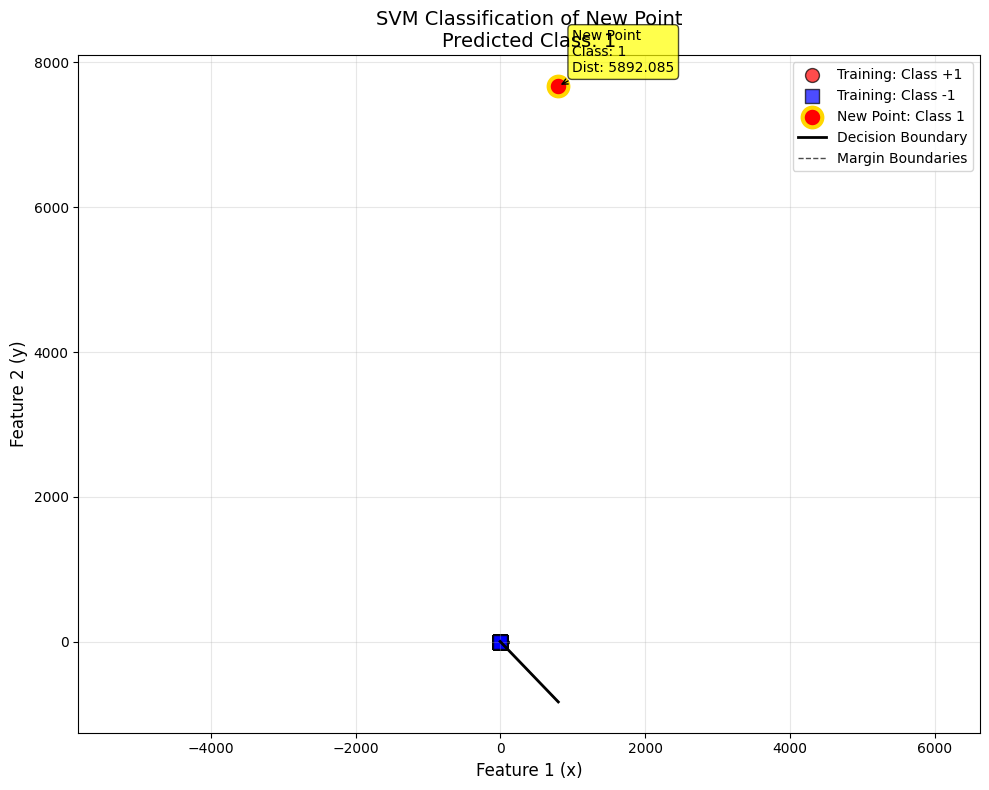

In [8]:
def classify_and_plot_new_point(new_point, X, y, a, b, c):
    """
    Classify a new point using the trained SVM and visualize it

    Parameters:
    new_point: tuple (x, y) - coordinates of the new point
    X, y: existing training data
    a, b, c: SVM coefficients from training
    """
    x_new, y_new = new_point

    # Classify the new point
    decision_value = a * x_new + b * y_new + c
    predicted_class = 1 if decision_value > 0 else -1

    # Calculate distance from decision boundary
    distance = abs(decision_value) / np.sqrt(a**2 + b**2)

    print(f"New point: ({x_new:.3f}, {y_new:.3f})")
    print(f"Decision value: {decision_value:.4f}")
    print(f"Predicted class: {predicted_class}")
    print(f"Distance from decision boundary: {distance:.4f}")
    print(f"Confidence: {'High' if distance > 1.0 else 'Low (within margin)'}")

    # Create the plot
    plt.figure(figsize=(10, 8))

    # Plot original training data
    mask_pos = y == 1
    mask_neg = y == -1

    plt.scatter(X[mask_pos, 0], X[mask_pos, 1], c='red', marker='o',
                s=100, label='Training: Class +1', edgecolors='black', linewidth=1, alpha=0.7)
    plt.scatter(X[mask_neg, 0], X[mask_neg, 1], c='blue', marker='s',
                s=100, label='Training: Class -1', edgecolors='black', linewidth=1, alpha=0.7)

    # Plot the new point with special styling
    new_color = 'red' if predicted_class == 1 else 'blue'
    new_marker = 'o' if predicted_class == 1 else 's'
    plt.scatter(x_new, y_new, c=new_color, marker=new_marker,
                s=200, label=f'New Point: Class {predicted_class}',
                edgecolors='gold', linewidth=3)

    # Add text annotation for the new point
    plt.annotate(f'New Point\nClass: {predicted_class}\nDist: {distance:.3f}',
                xy=(x_new, y_new), xytext=(10, 10),
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Plot decision boundary and margins
    x_min, x_max = min(X[:, 0].min(), x_new) - 1, max(X[:, 0].max(), x_new) + 1
    x_range = np.linspace(x_min, x_max, 100)

    if abs(b) > 1e-10:
        y_decision = -(a * x_range + c) / b
        y_margin_pos = -(a * x_range + c - 1) / b
        y_margin_neg = -(a * x_range + c + 1) / b

        plt.plot(x_range, y_decision, 'k-', linewidth=2, label='Decision Boundary')
        plt.plot(x_range, y_margin_pos, 'k--', linewidth=1, alpha=0.7, label='Margin Boundaries')
        plt.plot(x_range, y_margin_neg, 'k--', linewidth=1, alpha=0.7)
        plt.fill_between(x_range, y_margin_pos, y_margin_neg, alpha=0.1, color='gray')

    plt.xlabel('Feature 1 (x)', fontsize=12)
    plt.ylabel('Feature 2 (y)', fontsize=12)
    plt.title(f'SVM Classification of New Point\nPredicted Class: {predicted_class}', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage - you can change these coordinates to test different points
new_point = (798.5, 7671.5)  # Test point - you can modify this
classify_and_plot_new_point(new_point, X, y, a, b, c)
